# 1. Import Packages and load Data 

In [22]:
# %%writefile utils/my_utils.py

# Installation
# !python -m spacy download en_core_web_sm (# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER))
# !pip install scikit-learn
# !pip install textblob
# %pip install optuna (# Unlike !pip, %pip installs into the current Jupyter kernel's environment reliably)
# %pip install imblearn
# %pip install --upgrade optuna
# %pip install xgboost lightgbm
# %pip install shap

# Standard libraries
import os, io, datetime, sys, json
import shutil, subprocess, pathlib, shlex, platform
from tqdm import tqdm
import joblib
from pathlib import Path
import multiprocessing as mp

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Split to training and testing datasets
from sklearn.model_selection import train_test_split

# Feature scaling
from sklearn.preprocessing import PowerTransformer

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import (
    make_scorer, 
    roc_auc_score, 
    average_precision_score, 
    precision_score, 
    recall_score,
    fbeta_score,
)
from sklearn.base import clone
import sklearn
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import shap

#  Natural Language Processing (NLP)
import re, string
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nlt

True

In [53]:
root_dir = Path.cwd().parent
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

tfidf = pd.read_csv(data_dir/'tfidf_strkept_2.csv')
clinbert = pd.read_csv(data_dir/'clinbert_strkept_2.csv')
tfidfbert = pd.read_csv(data_dir/'tfidf_clinbert_strkept_2.csv')
clinbert_only = pd.read_csv(data_dir/'clinbert_2.csv')


# 2. Data Cleaning and EDA

## 2.1 Eliminate Non-Predictive or Redundant Columns

### Feature Selection Summary for Modeling

#### Columns to Keep (after preprocessing if needed):

- `length_of_icu_stay_hours`, `admit_to_disch_hours`  
  - hour-based durations.
- `note_length`, `word_count`  
  - Simple text-based numeric features — useful for modeling.
- `spacy_lemmas_n`, `advanced_spacy_lemmas_n`  
  - Counts of tokens/lemmas — useful numeric features.

#### Columns to Drop Before Modeling:

- `subject_id`, `hadm_id`, `icu_stay_id`, `note_id`  
  - Identifiers — not useful for modeling; drop unless used for grouping/joining.
- `note_text`, `spacy_lemmas`, `advanced_spacy_lemmas`  
  - Raw/semi-processed text — drop **after** extracting features.
- `admittime`, `dischtime`, `intime`, `outtime`, `next_admittime`
  - Already convert to durations or extract time features (e.g., time of day, length of stay).
- `lemma_text`  
  - Already apply to text vectorization (e.g., TF-IDF or ClinicalBERT).
- `length_of_icu_stay`, `admit_to_disch`, `days_to_next_admit`  
  - Day-based durations, redundent to hour-based durations or binary values which have been kept.

In [24]:
cols_to_drop = ['subject_id', 'hadm_id', 'note_id', 'note_text', 'admittime', 'dischtime', 'admit_to_disch', 'next_admittime', 'days_to_next_admit' ]

cols_to_keep = ['admit_to_disch_hours', 'note_length', 'word_count', 'advanced_spacy_lemmas_n', 'readmit_30days', 'icu_stay_count', 'total_icu_hours', 'time_to_first_icu_hours', 'last_icu_to_discharge_hours']

tfidf_elim = tfidf.drop(columns=cols_to_drop)
clinbert_elim = clinbert.drop(columns=cols_to_drop)
tfidfbert_elim = tfidfbert.drop(columns=cols_to_drop)

In [25]:
print(tfidf_elim.columns)

Index(['admit_to_disch_hours', 'readmit_30days', 'note_length', 'word_count',
       'advanced_spacy_lemmas_n', 'icu_stay_count', 'total_icu_hours',
       'time_to_first_icu_hours', 'last_icu_to_discharge_hours', 'tfidf__ab',
       ...
       'tfidf__xl daily', 'tfidf__year', 'tfidf__year ago', 'tfidf__year old',
       'tfidf__yeast', 'tfidf__yeast none', 'tfidf__yellow', 'tfidf__yes',
       'tfidf__yesterday', 'tfidf__yo'],
      dtype='object', length=2009)


## 2.2 Impute missing values

In [26]:
tfidf_elim_null = tfidf_elim.isnull().sum()
tfidf_elim_isnull = tfidf_elim_null[tfidf_elim_null > 0]
print(tfidf_elim_isnull)

time_to_first_icu_hours        7729
last_icu_to_discharge_hours    7729
dtype: int64


In [27]:
clinbert_elim_null = clinbert_elim.isnull().sum()
clinbert_elim_isnull = clinbert_elim_null[clinbert_elim_null > 0]
print(clinbert_elim_isnull)

time_to_first_icu_hours        7729
last_icu_to_discharge_hours    7729
dtype: int64


In [28]:
tfidfbert_elim_null = tfidfbert_elim.isnull().sum()
tfidfbert_elim_isnull = tfidfbert_elim_null[tfidfbert_elim_null > 0]
print(tfidfbert_elim_isnull)

time_to_first_icu_hours        7729
last_icu_to_discharge_hours    7729
dtype: int64


In [29]:
print(len(tfidf_elim.loc[tfidf_elim.total_icu_hours==0, :]))

7729


Set timing to full admission length for admissions without ICU stay

In [30]:
datasets = [tfidf_elim, clinbert_elim, tfidfbert_elim]
cols = ['time_to_first_icu_hours', 'last_icu_to_discharge_hours']

for d in datasets: 
    for c in cols:
        d.loc[:, c] = d[c].fillna(d['admit_to_disch_hours'])


In [31]:
tfidf_elim_null = tfidf_elim.isnull().sum()
tfidf_elim_isnull = tfidf_elim_null[tfidf_elim_null > 0]
print(tfidf_elim_isnull)

Series([], dtype: int64)


In [32]:
clinbert_elim_null = clinbert_elim.isnull().sum()
clinbert_elim_isnull = clinbert_elim_null[clinbert_elim_null > 0]
print(clinbert_elim_isnull)

Series([], dtype: int64)


In [33]:
tfidfbert_elim_null = tfidfbert_elim.isnull().sum()
tfidfbert_elim_isnull = tfidfbert_elim_null[tfidfbert_elim_null > 0]
print(tfidfbert_elim_isnull)

Series([], dtype: int64)


## 2.3 Visualize Relationships Between Variables

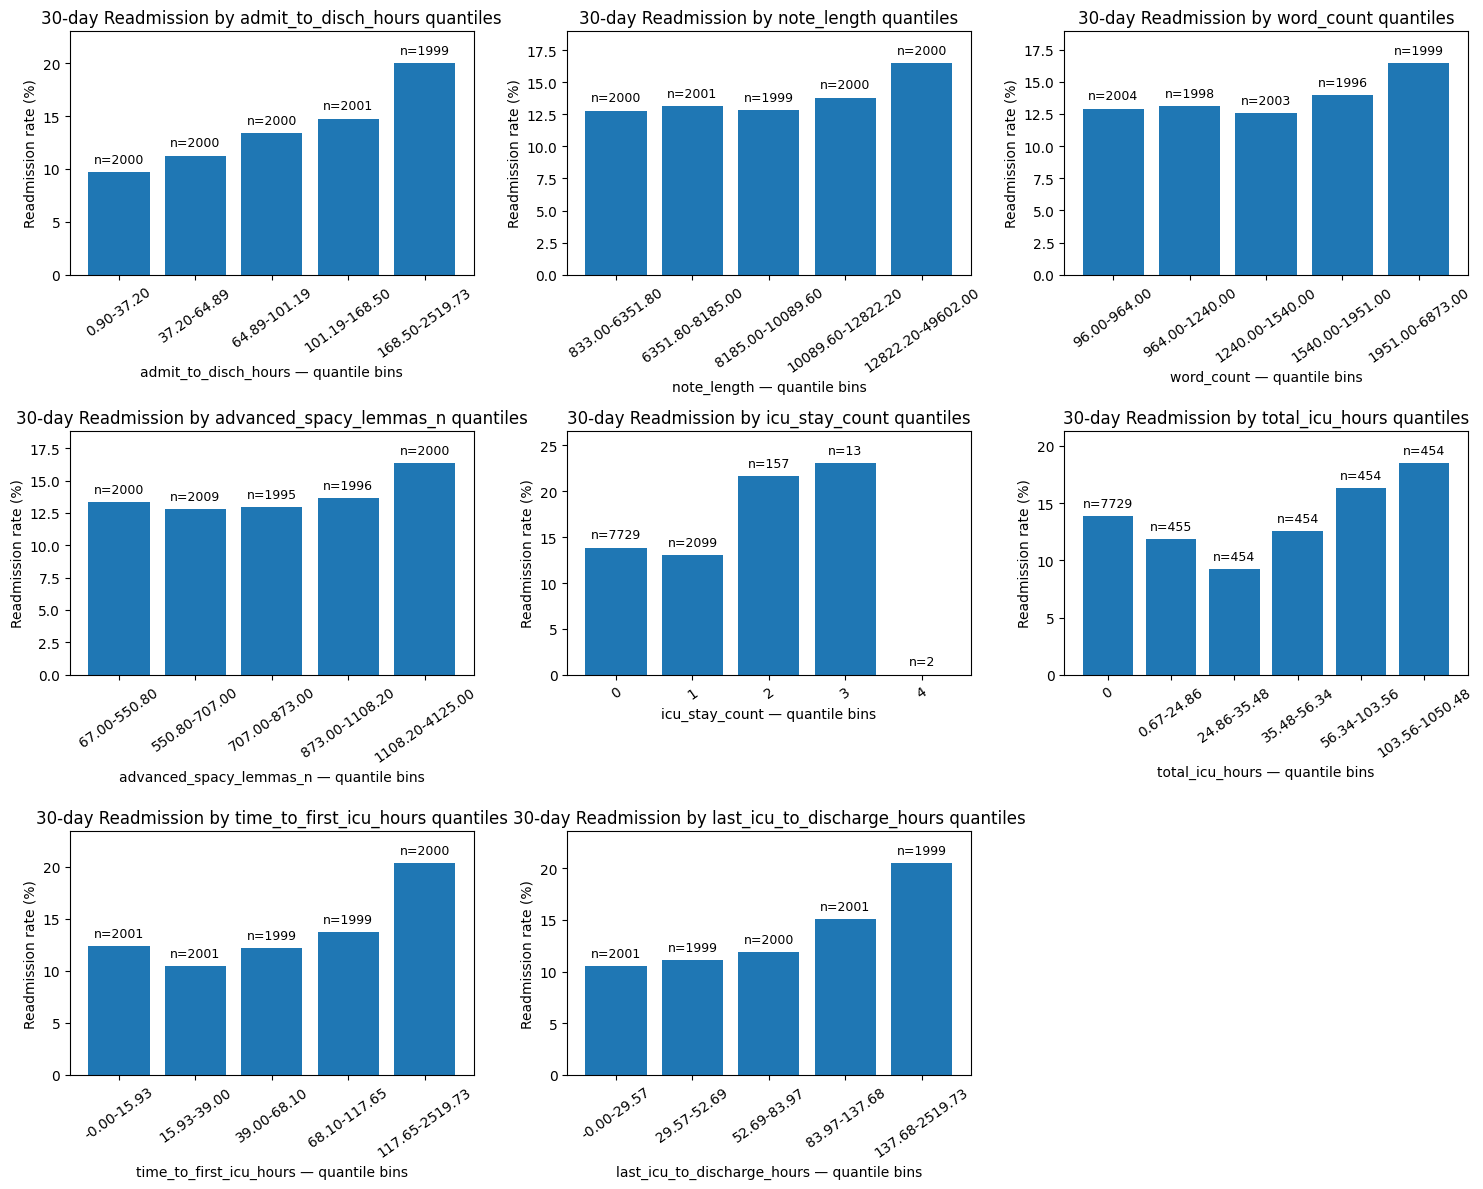

In [34]:
target = 'readmit_30days'
predictors = [c for c in cols_to_keep if c != target and c in tfidf_elim.columns]

n_bins = 5
zero_bar_cols = {'total_icu_hours'}   # still special-case zero for this col

n = len(predictors)
rows = cols = int(np.ceil(np.sqrt(n)))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = np.ravel(axes)

for i, col in enumerate(predictors):
    tmp = tfidf_elim[[col, target]].dropna().copy()

    # datetime/timedelta to numeric
    if np.issubdtype(tmp[col].dtype, np.timedelta64):
        tmp[col] = tmp[col].dt.total_seconds() / 3600.0
    if np.issubdtype(tmp[col].dtype, np.datetime64):
        tmp[col] = tmp[col].astype('int64')

    if col == 'icu_stay_count':
        # discrete bars: 0,1,2,3,4,(5+ if present)
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce').fillna(0).astype(int)
        tmp['bin'] = tmp[col]
        has_5plus = (tmp['bin'] >= 5).any()
        if has_5plus:
            tmp.loc[tmp['bin'] >= 5, 'bin'] = 5
            order = [0, 1, 2, 3, 4, 5]
            labels = ['0', '1', '2', '3', '4', '5+']
        else:
            order = [0, 1, 2, 3, 4]
            labels = ['0', '1', '2', '3', '4']
        tmp['bin'] = pd.Categorical(tmp['bin'], categories=order, ordered=True)
        show_labels = labels

    elif col in zero_bar_cols:
        # zero gets its own bar; non-zeros are quantile-binned
        mask0 = (tmp[col] == 0)
        bins = pd.Series(index=tmp.index, dtype="object")
        nz = tmp.loc[~mask0, col]

        if nz.empty:
            labels = []
        elif nz.nunique() == 1:
            single = f"{nz.iloc[0]:.2f}"
            bins.loc[~mask0] = single
            labels = [single]
        else:
            qbins = pd.qcut(nz, q=n_bins, duplicates='drop')
            cats = qbins.cat.categories
            labels = [f"{c.left:.2f}-{c.right:.2f}" for c in cats]
            qbins = qbins.cat.rename_categories(labels)
            bins.loc[~mask0] = qbins.astype(str)

        bins.loc[mask0] = '0'
        order = ['0'] + labels
        tmp['bin'] = pd.Categorical(bins, categories=order, ordered=True)
        show_labels = order

    else:
        # default: quantile bins
        qbins = pd.qcut(tmp[col], q=n_bins, duplicates='drop')
        cats = qbins.cat.categories
        labels = [f"{c.left:.2f}-{c.right:.2f}" for c in cats]
        tmp['bin'] = qbins.cat.rename_categories(labels)
        show_labels = labels

    # aggregate readmit rate per bin
    agg = (tmp.groupby('bin', observed=True)
              .agg(readmit_rate=(target, 'mean'), n=('bin', 'size'))
              .reset_index())
    agg['readmit_pct'] = 100 * agg['readmit_rate']

    # plot
    ax = axes[i]
    ax.bar(agg['bin'].astype(str), agg['readmit_pct'])
    ax.set_title(f"30-day Readmission by {col} quantiles")
    ax.set_xlabel(f"{col} — quantile bins")
    ax.set_ylabel("Readmission rate (%)")
    ax.tick_params(axis='x', rotation=35)

    ymax = agg['readmit_pct'].max() * 1.15
    ax.set_ylim(0, ymax)
    for p, (x, pct, n_) in enumerate(zip(agg['bin'].astype(str), agg['readmit_pct'], agg['n'])):
        ax.text(p, pct + agg['readmit_pct'].max()*0.03, f"n={n_}", ha='center', va='bottom', fontsize=9)

# clean extra axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 3. Feature Engineering

## 3.1 Examine the Distribution of Retained Variables

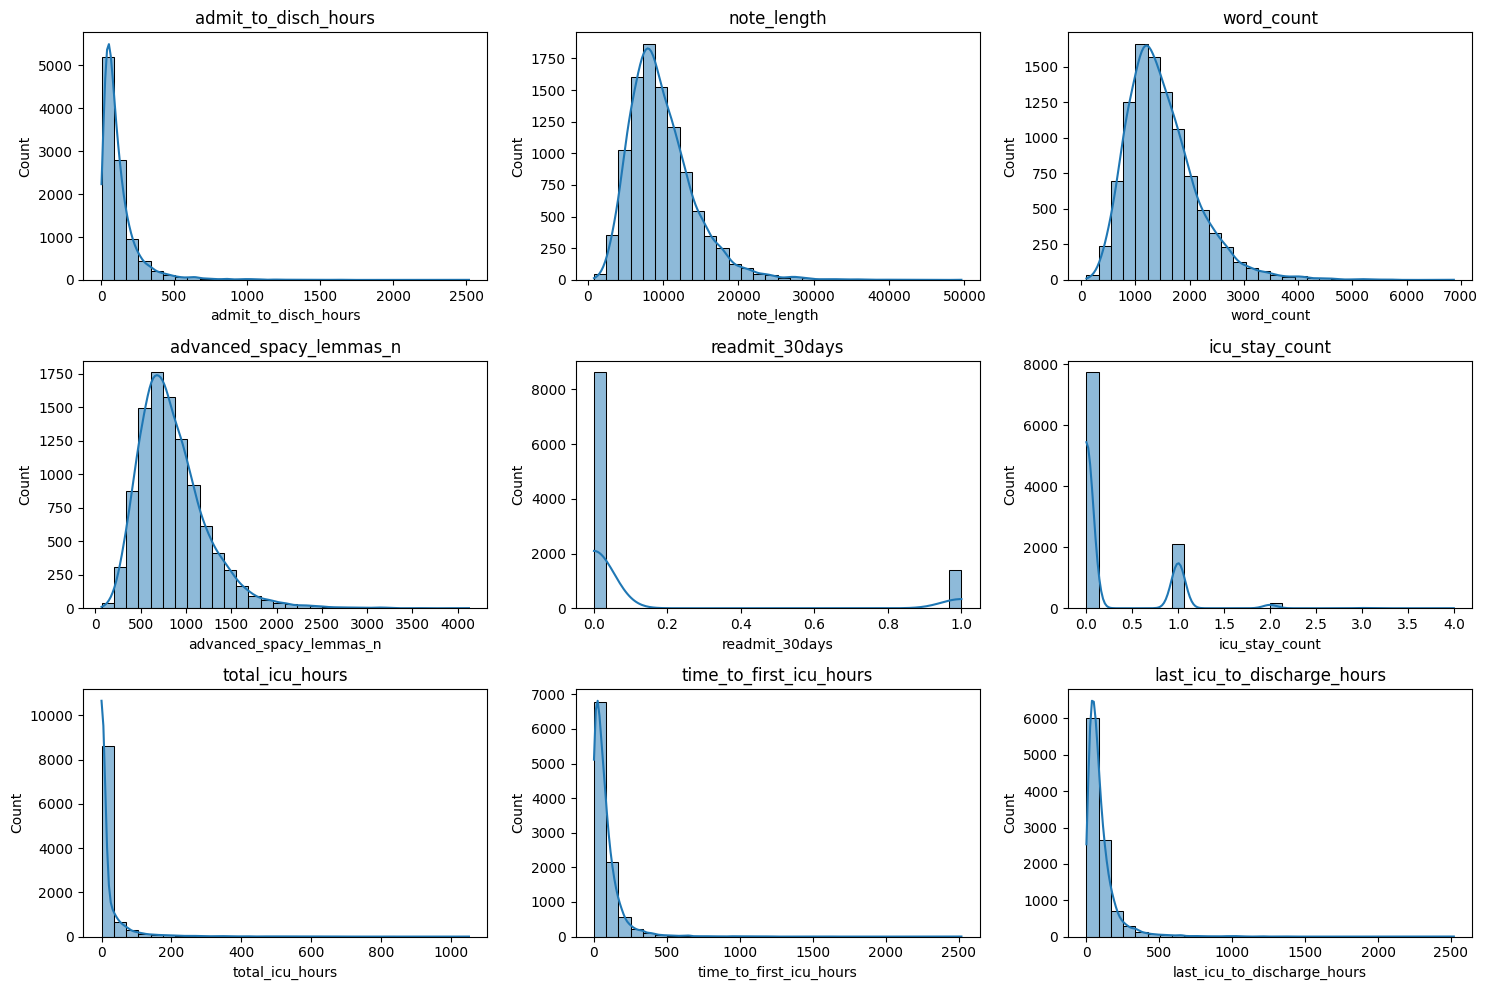

In [35]:
# Plot distributions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols_to_keep):
    sns.histplot(tfidf_elim[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 3.2 Assigned Scalers for Retained Variables

### Scaler Selection Logic

|Condition | Best Scaling Method |
|------------| -------------------- |
|Near-normal distributions with limited outliers| StandardScaler | 
|Non-Gaussian but no extreme outliers | MinMaxScaler | 
|Strong outliers, large spread, or moderate skew | RobustScaler | 
|Highly skewed (e.g., >1.0), heavy-tailed distribution | Log Transformation | 

In [36]:
# --- Make the project root importable ---------------------------------
import sys, pathlib

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

import importlib
import Mimic_Readmit_Clinbert.utils.auto_assign_scalers as aas

print(aas.__file__)            # sanity-check the path being imported
importlib.reload(aas)          # reload after saving your edits

from Mimic_Readmit_Clinbert.utils.auto_assign_scalers import auto_assign_scalers


c:\Users\Sheng Miao\OneDrive\桌面\DS\Capstone projects\Mimic_Readmit_Clinbert\utils\auto_assign_scalers.py


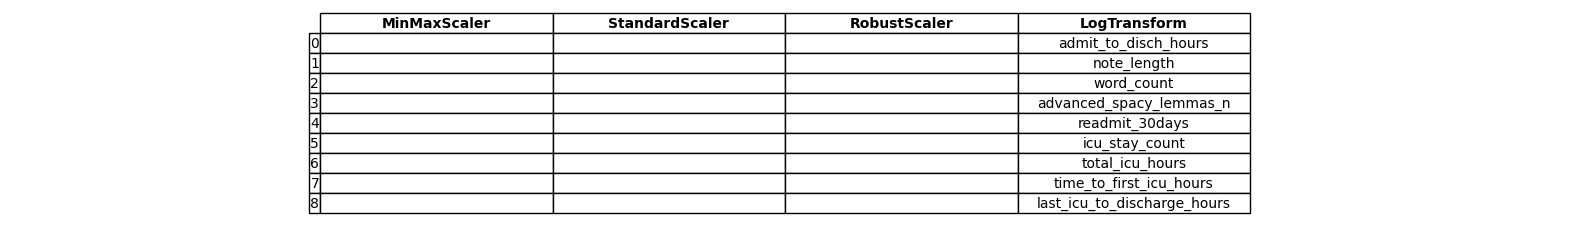

In [37]:
# Apply the customized function auto_assign_scalers() to classify 6 numerical variables
scaler_results, statistics = auto_assign_scalers(tfidf_elim, cols_to_keep)

# Display the assigned scalers for each variable
scaler_df = pd.DataFrame({key: pd.Series(val) for key, val in scaler_results.items()})
statistics_df = pd.DataFrame({key: pd.Series(val) for key, val in statistics.items()})
scaler_df = scaler_df.fillna('')

# Set up figure and axis
fig, ax = plt.subplots(figsize=(20, len(scaler_df) * 0.3))  # Adjust height based on number of rows

# Hide axes
ax.axis('off')

# Create the table and add it to the plot
table = pd.plotting.table(ax, scaler_df, loc='center', cellLoc='center', colWidths=[0.15]*len(scaler_df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Bold the header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')



## 3.3 Split Data into Training and Testing Sets first, then Apply Feature Scaling

In [38]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_elim.drop(columns=['readmit_30days']),
                                                    tfidf_elim['readmit_30days'], test_size=0.3, 
                                                    random_state=42)
X_train_clinbert, X_test_clinbert, y_train_clinbert, y_test_clinbert = train_test_split(clinbert_elim.drop(columns=['readmit_30days']),
                                                    clinbert_elim['readmit_30days'], test_size=0.3, 
                                                    random_state=42)
X_train_tfidfbert, X_test_tfidfbert, y_train_tfidfbert, y_test_tfidfbert = train_test_split(tfidfbert_elim.drop(columns=['readmit_30days']),
                                                    tfidfbert_elim['readmit_30days'], test_size=0.3, 
                                                    random_state=42)

In [39]:
X_train_tfidf_null = X_train_tfidf.isnull().sum()
X_train_tfidf_isnull = X_train_tfidf_null[X_train_tfidf_null > 0]
print(X_train_tfidf_isnull)

Series([], dtype: int64)


In [40]:
X_train_tfidf.loc[X_train_tfidf.time_to_first_icu_hours < 0, 'time_to_first_icu_hours']

Series([], Name: time_to_first_icu_hours, dtype: float64)

In [41]:
X_train_tfidf.loc[X_train_tfidf.last_icu_to_discharge_hours < 0, 'last_icu_to_discharge_hours']

Series([], Name: last_icu_to_discharge_hours, dtype: float64)

In [42]:
from Mimic_Readmit_Clinbert.utils.feature_scaling import feature_scaling
cols_to_scale = ['admit_to_disch_hours', 'note_length', 'word_count', 'advanced_spacy_lemmas_n', 'icu_stay_count', 'total_icu_hours', 'time_to_first_icu_hours', 'last_icu_to_discharge_hours']
X_train_tfidf, X_test_tfidf = feature_scaling(X_train_tfidf, X_test_tfidf, cols_to_scale, statistics)
X_train_clinbert, X_test_clinbert = feature_scaling(X_train_clinbert, X_test_clinbert, cols_to_scale, statistics)
X_train_tfidfbert, X_test_tfidfbert = feature_scaling(X_train_tfidfbert, X_test_tfidfbert, cols_to_scale, statistics)

In [43]:
X_train_tfidf[cols_to_scale].head()

,admit_to_disch_hours,note_length,word_count,advanced_spacy_lemmas_n,icu_stay_count,total_icu_hours,time_to_first_icu_hours,last_icu_to_discharge_hours
9069,2.472328,8.985570,7.075809,6.523562,0.000000,0.000000,2.472328,2.472328
2603,4.278285,9.021357,7.142827,6.502790,0.693147,3.919032,0.861482,3.063313
7738,4.227563,9.143239,7.287561,6.715383,0.000000,0.000000,4.227563,4.227563
1579,4.138893,9.048645,7.125283,6.507278,0.000000,0.000000,4.138893,4.138893
5058,4.243483,8.604288,6.792344,6.104793,0.000000,0.000000,4.243483,4.243483


In [44]:
X_test_tfidf[cols_to_scale].head()

,admit_to_disch_hours,note_length,word_count,advanced_spacy_lemmas_n,icu_stay_count,total_icu_hours,time_to_first_icu_hours,last_icu_to_discharge_hours
6252,4.747104,9.917292,8.033658,7.463937,0.693147,3.704596,0.980829,4.303385
4684,3.268935,9.310909,7.419980,6.870053,0.000000,0.000000,3.268935,3.268935
1731,6.165838,10.161921,8.275376,7.736307,0.693147,4.966159,3.869533,5.658804
4742,4.769978,9.205428,7.295056,6.637258,0.000000,0.000000,4.769978,4.769978
4521,5.050390,9.690356,7.796058,7.226209,0.000000,0.000000,5.050390,5.050390


In [45]:
from pathlib import Path

# ── 1. Locate / create the data folder ────────────────────────────────
root_dir = Path.cwd().parent            # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)           # won’t overwrite if it exists

# ── 2. Map *file-stem → object*  --------------------------------------
files = {
    "X_train_tfidf":      X_train_tfidf,
    "X_test_tfidf":       X_test_tfidf,
    "y_train_tfidf":      y_train_tfidf,
    "y_test_tfidf":       y_test_tfidf,

    "X_train_clinbert":      X_train_clinbert,
    "X_test_clinbert":       X_test_clinbert,
    "y_train_clinbert":      y_train_clinbert,
    "y_test_clinbert":       y_test_clinbert,

    "X_train_tfidfbert":     X_train_tfidfbert,
    "X_test_tfidfbert":      X_test_tfidfbert,
    "y_train_tfidfbert":     y_train_tfidfbert,
    "y_test_tfidfbert":      y_test_tfidfbert,
}

# ── 3. Write every DataFrame/Series once  -----------------------------
for stem, obj in files.items():
    # treat target vectors (Series) the same as DataFrames
    if stem.startswith("y_"):
        obj.to_csv(data_dir / f"{stem}.csv", index=False, header=True)
    else:
        obj.to_csv(data_dir / f"{stem}.csv", index=False)

In [46]:
# # Include versioning in the filename
# # Create version tag based on date or manual versioning
# version = "v1.0"
# timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# # Construct filename with version and timestamp
# filename = f"Saved/scaler_instances_{version}_{timestamp}.joblib"

# # Save metadata along with the object
# metadata = {
#     "scaler": scaler_instances,
#     "created_by": "Sheng Miao",
#     "date_saved": timestamp,
#     "version": version,
#     "description": "StandardScaler fitted on structured and TF-IDF combined dataset for 30-day readmission model"
# }

# joblib.dump(metadata, filename)

# 4. Modeling

load saved csv files

In [ ]:
# # Load in bulk

# import pandas as pd
# from pathlib import Path

# # ── 1. Point to the folder that holds the 12 files ─────────────────────
# root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
# data_dir = root_dir / "data"

# # ── 2. List the file stems I saved earlier ───────────────────────────
# stems = [
#     "X_train_tfidf",  "X_test_tfidf",  "y_train_tfidf",  "y_test_tfidf",
#     "X_train_clinbert",  "X_test_clinbert",  "y_train_clinbert",  "y_test_clinbert",
#     "X_train_tfidfbert", "X_test_tfidfbert", "y_train_tfidfbert", "y_test_tfidfbert",
# ]

# # ── 3. Bulk-load everything into a dict ────────────────────────────────
# loaded = {
#     stem: pd.read_csv(data_dir / f"{stem}.csv")
#     for stem in stems
# }

# # ── 4. Convert the y_… DataFrames (single column) to 1-D Series ────────
# for stem in stems:
#     if stem.startswith("y_"):
#         loaded[stem] = loaded[stem].squeeze("columns")

# # ── 5. Optionally put them back into the notebook’s global namespace ──
# globals().update(loaded)

# # I can now use variables directly:
# print(X_train_tfidf.shape, y_test_clinbert.head())


## 4.1 Logistic Regression + Optuna (with regulation)

### 4.1.1 TF-IDF + Structure Data

Reasons: 
- Handles high-dimensional sparse data (like TF-IDF) very well.
- Fast to train and easy to interpret (especially with L1 or L2 regularization).
- A solid baseline model.

The positive rate of my new dataset is ~14% now — that’s still imbalanced, but no longer “rare-event” territory as before (<1%). The main changes versus the <1% setup are:

- Don’t oversample by default (SMOTE can now hurt by inventing too many synthetic points). Keep it available only when really skewed.

- Tune/score with ROC-AUC (more stable when the class isn’t ultra-rare); still log Average-Precision.

- Don’t downsample negatives for tuning; use the full (or a stratified) set.

- Pick the decision threshold from out-of-fold probabilities (optimize F1), then report Precision/Recall at that threshold (not at 0.50). Threshold selection: we now compute out-of-fold probabilities and pick the threshold that maximizes F1, then report Precision/Recall at that threshold.

Here’s an updated code. It auto-adapts: if the positive rate falls below 5% again, it will switch back to SMOTE + AP.

**What “Pick threshold from out-of-fold probabilities” Means**

- During cross-validation (CV), you get out-of-fold predicted probabilities (i.e., predictions for validation sets not used in training).

- You can scan across thresholds (e.g., 0.01 to 0.99) and compute the F1 score at each.

- The threshold that maximizes F1 on CV is selected.

This ensures:

- The threshold choice is based on held-out predictions, not the training folds → less overfitting.

- Your final evaluation reports Precision and Recall at that chosen threshold, which better reflects how the model will behave in deployment.

**Why I need to pick the decision threshold at model tuning stage?** You don’t have to pick a threshold during hyperparameter tuning itself. But once you’ve tuned the model and want to report metrics like Precision/Recall/F1, you should pick the threshold based on out-of-fold probabilities — not arbitrarily 0.50 — because that gives a fairer, optimized picture of your model’s classification ability.

In [47]:
null = X_train_tfidf.isnull().sum()
isnu = null[null>0]
print(isnu)

Series([], dtype: int64)


In [ ]:
# ────────────────────────────── imports ───────────────────────────────
import os, warnings, json, logging
from logging.handlers import RotatingFileHandler
from pathlib import Path

import numpy as np
import pandas as pd
import optuna
from tqdm.auto import tqdm

from joblib import parallel_backend
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, precision_recall_curve
)

import matplotlib.pyplot as plt

# Optional: detect sparse matrices for SMOTE decision
try:
    import scipy.sparse as sp
except Exception:
    sp = None

# ───────────────────────────── config ────────────────────────────────
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED       = 42
N_SPLITS   = 5            # per request
N_TRIALS   = 25           # per request
N_JOBS_CV  = -1           # parallelize folds
MAX_ROWS   = None         # e.g., 80_000 to cap tuning size if desired
TOL        = 1e-3         # slightly relaxed for speed
PENALTIES  = ["l1", "l2", "elasticnet"]  # trim to ["l1","l2"] for more speed

# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

# Use a static filename so rotation actually works across runs
log_file  = saved_dir / "logreg_optuna_tfidf.log"

logger = logging.getLogger("logreg_optuna")
logger.setLevel(logging.INFO)
logger.propagate = False
# Rotate at ~2MB, keep 5 backups
_rot = RotatingFileHandler(log_file, maxBytes=2_000_000, backupCount=5, encoding="utf-8")
_rot.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
# Ensure we don't accidentally add multiple handlers if re-running the cell
if not logger.handlers:
    logger.addHandler(_rot)

log = logger.info  # convenience alias

# ─────────────────────────── data setup ───────────────────────────────
# Expect X_train_tfidf, y_train_tfidf already in memory
pos_rate = float(pd.Series(y_train_tfidf).mean())
primary_metric = "roc_auc" if pos_rate >= 0.05 else "average_precision"

def build_tuning_subset(X, y, pos_rate, max_rows=None):
    # For very imbalanced data, keep all positives but cap negatives
    if pos_rate < 0.05:
        y_ser = pd.Series(y)
        pos_idx = y_ser[y_ser == 1].index
        neg_pool = y_ser[y_ser == 0].index
        n_neg = min(1_000, len(neg_pool))
        neg_idx = y_ser.loc[neg_pool].sample(n=n_neg, random_state=SEED).index
        idx = pos_idx.union(neg_idx)
        if hasattr(X, "loc"):
            return X.loc[idx], y_ser.loc[idx]
        return X[idx], y_ser.loc[idx]
    # Else optionally cap very large datasets
    if (max_rows is not None) and (len(y) > max_rows):
        y_ser = pd.Series(y)
        frac = max_rows / len(y_ser)
        keep = y_ser.groupby(y_ser).apply(lambda s: s.sample(frac=frac, random_state=SEED)).index.get_level_values(1)
        if hasattr(X, "loc"):
            return X.loc[keep], y_ser.loc[keep]
        return X[keep], y_ser.loc[keep]
    return X, pd.Series(y)

X_tune, y_tune = build_tuning_subset(X_train_tfidf, y_train_tfidf, pos_rate, max_rows=MAX_ROWS)

IS_SPARSE = sp is not None and (sp.issparse(X_tune) or (hasattr(X_tune, "sparse") and X_tune.sparse))
USE_SMOTE = (pos_rate < 0.05) and (not IS_SPARSE)  # avoid SMOTE on sparse TF-IDF

cv  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
results      = {}
metric_table = []  # rows: penalty, ROC_AUC, AP, F1, Precision, Recall, Threshold, Best_Params

# Log initial setup (to file only)
log(f"Positive rate: {pos_rate:.4%}")
log(f"Primary scoring: {primary_metric} | Sparse: {IS_SPARSE} | SMOTE: {USE_SMOTE}")
log(f"Splits={N_SPLITS}, Trials={N_TRIALS}, n_jobs={N_JOBS_CV}, tol={TOL}, penalties={PENALTIES}")

# ───────────────────────── optimisation (progress bars on) ────────────
def objective(trial, penalty):
    """Optuna objective: maximize primary_metric."""
    C = trial.suggest_float("C", 1e-5, 1e2, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    params = dict(
        penalty=penalty, C=C, solver="saga", max_iter=3_000,
        random_state=SEED, class_weight=class_weight, tol=TOL
    )
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

    steps = []
    if USE_SMOTE:
        steps.append(("smote", SMOTE(random_state=SEED)))
    steps.append(("clf", LogisticRegression(**params)))
    pipe = ImbPipeline(steps)

    with parallel_backend("loky", inner_max_num_threads=1):
        score = cross_val_score(
            pipe, X_tune, y_tune, cv=cv, scoring=primary_metric, n_jobs=N_JOBS_CV
        )
    return score.mean()

for pen in tqdm(PENALTIES, desc="Penalties", position=0):
    log(f"Optimising penalty={pen}")
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    # Optuna's own progress bar prints to console; other details go to log file
    study.optimize(lambda tr: objective(tr, pen), n_trials=N_TRIALS, show_progress_bar=True)
    best_primary = study.best_value
    best_params  = study.best_params
    log(f" best {primary_metric}: {best_primary:.6f}")
    log(f" best params: {best_params}")

    # ── OOF probabilities & F1-optimal threshold ──
    best_params_full = dict(
        penalty=pen, solver="saga", max_iter=3_000, random_state=SEED, tol=TOL,
        **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio", "class_weight")}
    )
    steps = []
    if USE_SMOTE:
        steps.append(("smote", SMOTE(random_state=SEED)))
    steps.append(("clf", LogisticRegression(**best_params_full)))
    pipe = ImbPipeline(steps)

    with parallel_backend("loky", inner_max_num_threads=1):
        probas = cross_val_predict(
            pipe, X_tune, y_tune, cv=cv, method="predict_proba", n_jobs=N_JOBS_CV
        )[:, 1]

    prec, rec, thr = precision_recall_curve(y_tune, probas)
    f1_vals = (2 * prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-12, None)
    best_thr = 0.5 if (len(f1_vals) == 0 or np.all(np.isnan(f1_vals))) else float(thr[np.nanargmax(f1_vals)])

    y_pred = (probas >= best_thr).astype(int)
    roc = roc_auc_score(y_tune, probas)
    ap  = average_precision_score(y_tune, probas)
    f1  = f1_score(y_tune, y_pred, zero_division=0)
    p_  = precision_score(y_tune, y_pred, zero_division=0)
    r_  = recall_score(y_tune, y_pred, zero_division=0)

    results[pen] = best_primary
    metric_table.append(dict(
        Penalty=pen, ROC_AUC=roc, Avg_Precision=ap,
        F1=f1, Precision=p_, Recall=r_, Threshold=best_thr,
        Best_Params=best_params_full
    ))
    log(f"  OOF ROC-AUC={roc:.6f} | AP={ap:.6f} | F1={f1:.6f} @ thr={best_thr:.3f} (P={p_:.3f}, R={r_:.3f})")

# ───────────────── save outputs (no console prints) ───────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
summary_csv = saved_dir / "logreg_penalties_summary.csv"
summary_df.to_csv(summary_csv)
log(f"Saved summary: {summary_csv}")

# Save params as JSON for easy reuse
params_json = saved_dir / "logreg_best_params.json"
with open(params_json, "w", encoding="utf-8") as f:
    json.dump({row["Penalty"]: row["Best_Params"] for row in metric_table}, f, indent=2)
log(f"Saved best params JSON: {params_json}")

# Save grouped bar chart to file (no plt.show())
fig, ax = plt.subplots(figsize=(9, 4))
x     = np.arange(len(summary_df))
width = 0.25
ax.bar(x - width, summary_df["ROC_AUC"],       width, label="ROC-AUC")
ax.bar(x,         summary_df["F1"],            width, label="F1 (best thr)")
ax.bar(x + width, summary_df["Avg_Precision"], width, label="Avg Precision")
ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Penalties – ROC-AUC, F1 (best thr), Avg Precision")
ax.legend()
plt.tight_layout()
plot_path = saved_dir / "logreg_penalties_scores.png"
plt.savefig(plot_path, dpi=160)
plt.close(fig)
log(f"Saved plot: {plot_path}")

# 142m 53.0s


Penalties:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### 4.1.2 ClinicBERT + Structure Data

**What I adjusted specifically for ClinBERT + numeric:**

- Scaling added: StandardScaler(with_mean=True for dense) improves LR stability/fit on 768-d embeddings. (Automatically uses with_mean=False if your matrix is sparse—e.g., TF-IDF.)

- SMOTE gated off for high-dim embeddings: USE_SMOTE only true if imbalanced and dense and n_features <= 200. In 768-d space, SMOTE is slow and usually unhelpful—class_weight="balanced" generally wins.

- Higher max_iter (5,000): gives SAGA more room to converge on dense, high-dim data.

- Auto-dataset detection: picks ClinBERT if available; filenames and logs include a dataset tag so runs don’t collide.

In [ ]:
# ────────────────────────────── imports ───────────────────────────────
import os, warnings, json, logging
from logging.handlers import RotatingFileHandler
from pathlib import Path

import numpy as np
import pandas as pd
import optuna
from tqdm.auto import tqdm

from joblib import parallel_backend
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, precision_recall_curve
)

import matplotlib.pyplot as plt

# Optional: detect sparse matrices for TF-IDF decisioning
try:
    import scipy.sparse as sp
except Exception:
    sp = None

# ───────────────────────────── config ────────────────────────────────
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED       = 42
N_SPLITS   = 5           # keep 5-fold CV
N_TRIALS   = 25          # 25 Optuna trials per penalty
N_JOBS_CV  = -1          # parallelize folds
MAX_ROWS   = None        # e.g., 80_000 to cap tuning size if desired
TOL        = 1e-3        # slightly relaxed for speed
PENALTIES  = ["l1", "l2", "elasticnet"]  # trim to ["l1","l2"] for more speed

# ───────────── Explicit dataset: ClinBERT  ─────────────

X_train = X_train_clinbert
y_train = y_train_clinbert 
DATASET_TAG = "clinbert"

# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

# Rotate logs; distinct file per dataset tag
log_file  = saved_dir / f"logreg_optuna_{DATASET_TAG}.log"

logger = logging.getLogger(f"logreg_optuna_{DATASET_TAG}")
logger.setLevel(logging.INFO)
logger.propagate = False
_rot = RotatingFileHandler(log_file, maxBytes=2_000_000, backupCount=5, encoding="utf-8")
_rot.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
if not logger.handlers:
    logger.addHandler(_rot)
log = logger.info

# ─────────────────────────── data setup ───────────────────────────────
pos_rate = float(pd.Series(y_train).mean())
primary_metric = "roc_auc" if pos_rate >= 0.05 else "average_precision"

def build_tuning_subset(X, y, pos_rate, max_rows=None):
    y_ser = pd.Series(y)
    # Very imbalanced: keep all positives, cap negatives
    if pos_rate < 0.05:
        pos_idx = y_ser[y_ser == 1].index
        neg_pool = y_ser[y_ser == 0].index
        n_neg = min(1_000, len(neg_pool))
        neg_idx = y_ser.loc[neg_pool].sample(n=n_neg, random_state=SEED).index
        idx = pos_idx.union(neg_idx)
        if hasattr(X, "loc"):
            return X.loc[idx], y_ser.loc[idx]
        return X[idx], y_ser.loc[idx]
    # Else optionally cap very large datasets
    if (max_rows is not None) and (len(y_ser) > max_rows):
        frac = max_rows / len(y_ser)
        keep = y_ser.groupby(y_ser).apply(lambda s: s.sample(frac=frac, random_state=SEED)).index.get_level_values(1)
        if hasattr(X, "loc"):
            return X.loc[keep], y_ser.loc[keep]
        return X[keep], y_ser.loc[keep]
    return X, y_ser

X_tune, y_tune = build_tuning_subset(X_train, y_train, pos_rate, max_rows=MAX_ROWS)

# Sparse vs dense + dimensionality (used to decide SMOTE and scaling)
IS_SPARSE = sp is not None and (sp.issparse(X_tune) or (hasattr(X_tune, "sparse") and X_tune.sparse))
N_FEATS   = (X_tune.shape[1] if hasattr(X_tune, "shape") and len(getattr(X_tune, "shape", ())) >= 2 else None)

# ClinBERT is dense (768-d) → scale; SMOTE in 768-d is slow/low-yield, so gate it off.
# TF-IDF is usually sparse → scale with_mean=False; avoid SMOTE for sparse matrices.
USE_SMOTE = (pos_rate < 0.05) and (not IS_SPARSE) and (N_FEATS is not None and N_FEATS <= 200)
# ^ Heuristic: only allow SMOTE if imbalanced + dense + relatively low-dim (<=200)

cv  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
results      = {}
metric_table = []  # rows: penalty, ROC_AUC, AP, F1, Precision, Recall, Threshold, Best_Params

log(f"[{DATASET_TAG}] Positive rate: {pos_rate:.4%}")
log(f"[{DATASET_TAG}] Primary scoring: {primary_metric} | Sparse={IS_SPARSE} | n_features={N_FEATS} | SMOTE={USE_SMOTE}")
log(f"[{DATASET_TAG}] Splits={N_SPLITS}, Trials={N_TRIALS}, n_jobs={N_JOBS_CV}, tol={TOL}, penalties={PENALTIES}")

# ───────────────────────── optimisation (progress bars on) ────────────
def build_pipe(params):
    steps = []
    # Scale always: with_mean=False for sparse; True for dense (ClinBERT)
    steps.append(("scaler", StandardScaler(with_mean=not IS_SPARSE)))
    if USE_SMOTE:
        steps.append(("smote", SMOTE(random_state=SEED)))
    steps.append(("clf", LogisticRegression(**params)))
    return ImbPipeline(steps)

def objective(trial, penalty):
    """Optuna objective: maximize primary_metric."""
    C = trial.suggest_float("C", 1e-5, 1e2, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    params = dict(
        penalty=penalty, C=C, solver="saga", max_iter=5_000,  # ↑ max_iter for 768-d ClinBERT
        random_state=SEED, class_weight=class_weight, tol=TOL, n_jobs=1
    )
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

    pipe = build_pipe(params)
    # Parallelize across folds; keep inner threads at 1 to avoid oversubscription
    with parallel_backend("loky", inner_max_num_threads=1):
        score = cross_val_score(
            pipe, X_tune, y_tune, cv=cv, scoring=primary_metric, n_jobs=N_JOBS_CV
        )
    return score.mean()

for pen in tqdm(PENALTIES, desc=f"Penalties ({DATASET_TAG})", position=0):
    log(f"[{DATASET_TAG}] Optimising penalty={pen}")
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda tr: objective(tr, pen), n_trials=N_TRIALS, show_progress_bar=True)
    best_primary = study.best_value
    best_params  = study.best_params
    log(f"[{DATASET_TAG}] best {primary_metric}: {best_primary:.6f}")
    log(f"[{DATASET_TAG}] best params: {best_params}")

    # ── OOF probabilities & F1-optimal threshold ──
    best_params_full = dict(
        penalty=pen, solver="saga", max_iter=5_000, random_state=SEED, tol=TOL, n_jobs=1,
        **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio", "class_weight")}
    )
    pipe = build_pipe(best_params_full)

    with parallel_backend("loky", inner_max_num_threads=1):
        probas = cross_val_predict(
            pipe, X_tune, y_tune, cv=cv, method="predict_proba", n_jobs=N_JOBS_CV
        )[:, 1]

    prec, rec, thr = precision_recall_curve(y_tune, probas)
    f1_vals = (2 * prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-12, None)
    best_thr = 0.5 if (len(f1_vals) == 0 or np.all(np.isnan(f1_vals))) else float(thr[np.nanargmax(f1_vals)])

    y_pred = (probas >= best_thr).astype(int)
    roc = roc_auc_score(y_tune, probas)
    ap  = average_precision_score(y_tune, probas)
    f1  = f1_score(y_tune, y_pred, zero_division=0)
    p_  = precision_score(y_tune, y_pred, zero_division=0)
    r_  = recall_score(y_tune, y_pred, zero_division=0)

    results[pen] = best_primary
    metric_table.append(dict(
        Penalty=pen, ROC_AUC=roc, Avg_Precision=ap,
        F1=f1, Precision=p_, Recall=r_, Threshold=best_thr,
        Best_Params=best_params_full
    ))
    log(f"[{DATASET_TAG}]  OOF ROC-AUC={roc:.6f} | AP={ap:.6f} | F1={f1:.6f} @ thr={best_thr:.3f} (P={p_:.3f}, R={r_:.3f})")

# ───────────────── save outputs (no console prints) ───────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
summary_csv = saved_dir / f"logreg_penalties_summary_{DATASET_TAG}.csv"
summary_df.to_csv(summary_csv)
log(f"[{DATASET_TAG}] Saved summary: {summary_csv}")

# Save params as JSON for easy reuse
params_json = saved_dir / f"logreg_best_params_{DATASET_TAG}.json"
with open(params_json, "w", encoding="utf-8") as f:
    json.dump({row["Penalty"]: row["Best_Params"] for row in metric_table}, f, indent=2)
log(f"[{DATASET_TAG}] Saved best params JSON: {params_json}")

# Save grouped bar chart to file (no plt.show())
fig, ax = plt.subplots(figsize=(9, 4))
x     = np.arange(len(summary_df))
width = 0.25
ax.bar(x - width, summary_df["ROC_AUC"],       width, label="ROC-AUC")
ax.bar(x,         summary_df["F1"],            width, label="F1 (best thr)")
ax.bar(x + width, summary_df["Avg_Precision"], width, label="Avg Precision")
ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title(f"Penalties – ROC-AUC, F1 (best thr), Avg Precision [{DATASET_TAG}]")
ax.legend()
plt.tight_layout()
plot_path = saved_dir / f"logreg_penalties_scores_{DATASET_TAG}.png"
plt.savefig(plot_path, dpi=160)
plt.close(fig)
log(f"[{DATASET_TAG}] Saved plot: {plot_path}")

# 35m 21.5s


Penalties (clinbert):   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### 4.1.3 TF-DF + ClinicBERT + Structure Data

Tuned for tfidfbert dataset (few numeric + 768 ClinicalBERT embeddings + 2000 TF-IDF).
Key adjustments vs. TF-IDF-only setup:

- Uses penalties = ["l2","elasticnet"] (better for high-dim dense+ sparse mix).
- C search tightened to [1e-4, 10] (stronger regularization typical for embeddings).
- SMOTE disabled by default (very high-dim + embeddings → SMOTE is slow and noisy).
- File names switched to tfidfbert to avoid confusion in saved artifacts.
- Keeps: N_SPLITS=5, N_TRIALS=25, progress bars, rotating log file, no console spam (besides the bars).
- Replace X_train_tfidfbert / y_train_tfidfbert with your actual variables if different.
- StandardScaler applied to the ClinicalBERT embedding columns, while passing TF-IDF columns (prefixed tfidf__) through unchanged.

In [54]:
# ────────────────────────────── imports ───────────────────────────────
import os, warnings, json, logging
from logging.handlers import RotatingFileHandler
from pathlib import Path

import numpy as np
import pandas as pd
import optuna
from tqdm.auto import tqdm

from joblib import parallel_backend
from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTE  # intentionally unused for tfidf+embeddings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, precision_recall_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Optional: detect sparse matrices (TF-IDF may be sparse)
try:
    import scipy.sparse as sp
except Exception:
    sp = None

# ───────────────────────────── config ────────────────────────────────
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED       = 42
N_SPLITS   = 5            # per request
N_TRIALS   = 25           # per request
N_JOBS_CV  = -1           # parallelize folds
MAX_ROWS   = None         # e.g., 120_000 to cap tuning size if desired
TOL        = 1e-3         # slightly relaxed for speed
# For embeddings + TF-IDF, prefer L2 / ElasticNet; L1 can be slower/unstable here
PENALTIES  = ["l2", "elasticnet"]

# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

# Rotating log file (no console growth)
log_file  = saved_dir / "logreg_optuna_tfidfbert.log"
logger = logging.getLogger("logreg_optuna_tfidfbert")
logger.setLevel(logging.INFO)
logger.propagate = False
_rot = RotatingFileHandler(log_file, maxBytes=2_000_000, backupCount=5, encoding="utf-8")
_rot.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
if not logger.handlers:
    logger.addHandler(_rot)
log = logger.info

# ─────────────────────────── data setup ───────────────────────────────
# EXPECT these objects to exist in memory:
#   X_train_tfidfbert : DataFrame / array-like / scipy.sparse
#   y_train_tfidfbert : array-like / Series
#   clinbert_only     : DataFrame with ONLY the 768 ClinicalBERT embedding columns
X_train = X_train_tfidfbert
y_train = y_train_tfidfbert

pos_rate = float(pd.Series(y_train).mean())
primary_metric = "roc_auc" if pos_rate >= 0.05 else "average_precision"

def build_tuning_subset(X, y, pos_rate, max_rows=None):
    y_ser = pd.Series(y)
    # For very imbalanced data, keep all positives but cap negatives (no SMOTE here)
    if pos_rate < 0.05:
        pos_idx = y_ser[y_ser == 1].index
        neg_pool = y_ser[y_ser == 0].index
        n_neg = min(2_000, len(neg_pool))  # allow more negatives than TF-IDF-only case
        neg_idx = y_ser.loc[neg_pool].sample(n=n_neg, random_state=SEED).index
        idx = pos_idx.union(neg_idx)
        if hasattr(X, "loc"):
            return X.loc[idx], y_ser.loc[idx]
        return X[idx], y_ser.loc[idx]
    # Else optionally cap very large datasets
    if (max_rows is not None) and (len(y_ser) > max_rows):
        frac = max_rows / len(y_ser)
        keep = y_ser.groupby(y_ser).apply(lambda s: s.sample(frac=frac, random_state=SEED)).index.get_level_values(1)
        if hasattr(X, "loc"):
            return X.loc[keep], y_ser.loc[keep]
        return X[keep], y_ser.loc[keep]
    return X, y_ser

X_tune, y_tune = build_tuning_subset(X_train, y_train, pos_rate, max_rows=MAX_ROWS)

# ─────────────────────────── column groups ────────────────────────────
# We standardize ONLY the ClinicalBERT embedding columns (dense).
# TF-IDF columns (prefix "tfidf__") are passed through unchanged.
preprocessor = None
if hasattr(X_tune, "columns"):
    # Ensure we only scale columns present in X_tune
    clinbert_cols_all = list(getattr(clinbert_only, "columns", []))
    clinbert_cols = [c for c in clinbert_cols_all if c in X_tune.columns]
    tfidf_cols    = [c for c in X_tune.columns if str(c).startswith("tfidf__")]
    other_cols    = [c for c in X_tune.columns if c not in clinbert_cols + tfidf_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ("clinbert_scale", StandardScaler(with_mean=True), clinbert_cols),  # dense scaler
            ("tfidf_pass", "passthrough", tfidf_cols),                          # sparse passthrough
            ("other_pass", "passthrough", other_cols),                          # e.g., your few numeric feats
        ],
        remainder="drop",
        n_jobs=None,  # let sklearn manage internally
        verbose_feature_names_out=False
    )

# Detect sparsity (combined matrix may become dense due to scaling block)
IS_SPARSE = sp is not None and (sp.issparse(X_tune) or (hasattr(X_tune, "sparse") and X_tune.sparse))
USE_SMOTE = False  # keep off for high-dim mixed set

cv  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
results      = {}
metric_table = []  # rows: penalty, ROC_AUC, AP, F1, Precision, Recall, Threshold, Best_Params

# Log initial setup
log(f"[tfidfbert] Positive rate: {pos_rate:.4%}")
log(f"[tfidfbert] Primary scoring: {primary_metric} | Input sparse: {IS_SPARSE} | SMOTE: {USE_SMOTE}")
if preprocessor is not None:
    log(f"[tfidfbert] Columns → clinbert_scale={len(clinbert_cols)}, tfidf_pass={len(tfidf_cols)}, other_pass={len(other_cols)}")
else:
    log("[tfidfbert] WARNING: X_tune has no .columns; proceeding WITHOUT column-wise scaling.")
log(f"[tfidfbert] Splits={N_SPLITS}, Trials={N_TRIALS}, n_jobs={N_JOBS_CV}, tol={TOL}, penalties={PENALTIES}")

# ───────────────────────── optimisation (progress bars on) ────────────
def make_pipeline(params):
    steps = []
    if preprocessor is not None:
        steps.append(("prep", preprocessor))
    steps.append(("clf", LogisticRegression(**params)))
    return ImbPipeline(steps)

def objective(trial, penalty):
    """Optuna objective: maximize primary_metric for tfidf+embeddings."""
    # Narrower C range typical for embeddings; prevents overfit & speeds search
    C = trial.suggest_float("C", 1e-4, 10.0, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    params = dict(
        penalty=penalty, C=C, solver="saga", max_iter=3_000,
        random_state=SEED, class_weight=class_weight, tol=TOL
    )
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

    pipe = make_pipeline(params)

    with parallel_backend("loky", inner_max_num_threads=1):
        score = cross_val_score(
            pipe, X_tune, y_tune, cv=cv, scoring=primary_metric, n_jobs=N_JOBS_CV
        )
    return score.mean()

for pen in tqdm(PENALTIES, desc="Penalties (tfidfbert)", position=0):
    log(f"[tfidfbert] Optimising penalty={pen}")
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    # Optuna progress bar shows in console; details go to log file
    study.optimize(lambda tr: objective(tr, pen), n_trials=N_TRIALS, show_progress_bar=True)
    best_primary = study.best_value
    best_params  = study.best_params
    log(f"[tfidfbert] best {primary_metric}: {best_primary:.6f}")
    log(f"[tfidfbert] best params: {best_params}")

    # ── OOF probabilities & F1-optimal threshold ──
    best_params_full = dict(
        penalty=pen, solver="saga", max_iter=3_000, random_state=SEED, tol=TOL,
        **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio", "class_weight")}
    )
    pipe = make_pipeline(best_params_full)

    with parallel_backend("loky", inner_max_num_threads=1):
        probas = cross_val_predict(
            pipe, X_tune, y_tune, cv=cv, method="predict_proba", n_jobs=N_JOBS_CV
        )[:, 1]

    prec, rec, thr = precision_recall_curve(y_tune, probas)
    f1_vals = (2 * prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-12, None)
    best_thr = 0.5 if (len(f1_vals) == 0 or np.all(np.isnan(f1_vals))) else float(thr[np.nanargmax(f1_vals)])

    y_pred = (probas >= best_thr).astype(int)
    roc = roc_auc_score(y_tune, probas)
    ap  = average_precision_score(y_tune, probas)
    f1  = f1_score(y_tune, y_pred, zero_division=0)
    p_  = precision_score(y_tune, y_pred, zero_division=0)
    r_  = recall_score(y_tune, y_pred, zero_division=0)

    results[pen] = best_primary
    metric_table.append(dict(
        Penalty=pen, ROC_AUC=roc, Avg_Precision=ap,
        F1=f1, Precision=p_, Recall=r_, Threshold=best_thr,
        Best_Params=best_params_full
    ))
    log(f"[tfidfbert] OOF ROC-AUC={roc:.6f} | AP={ap:.6f} | F1={f1:.6f} @ thr={best_thr:.3f} (P={p_:.3f}, R={r_:.3f})")

# ───────────────── save outputs (no console prints) ───────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
summary_csv = saved_dir / "logreg_tfidfbert_penalties_summary.csv"
summary_df.to_csv(summary_csv)
log(f"[tfidfbert] Saved summary: {summary_csv}")

# Save params as JSON for easy reuse
params_json = saved_dir / "logreg_tfidfbert_best_params.json"
with open(params_json, "w", encoding="utf-8") as f:
    json.dump({row["Penalty"]: row["Best_Params"] for row in metric_table}, f, indent=2)
log(f"[tfidfbert] Saved best params JSON: {params_json}")

# Save grouped bar chart to file
fig, ax = plt.subplots(figsize=(9, 4))
x     = np.arange(len(summary_df))
width = 0.25
ax.bar(x - width, summary_df["ROC_AUC"],       width, label="ROC-AUC")
ax.bar(x,         summary_df["F1"],            width, label="F1 (best thr)")
ax.bar(x + width, summary_df["Avg_Precision"], width, label="Avg Precision")
ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("TFIDF+BERT – Penalties: ROC-AUC, F1@best thr, AP")
ax.legend()
plt.tight_layout()
plot_path = saved_dir / "logreg_tfidfbert_penalties_scores.png"
plt.savefig(plot_path, dpi=160)
plt.close(fig)
log(f"[tfidfbert] Saved plot: {plot_path}")


# New Version made on 8/27/2025, Ready to run


Penalties (tfidfbert):   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## 4.2 Gradient Boosting XGBoost + Optuna 

### 4.2.1 TF-IDF + Structure Data

In [60]:
%matplotlib inline

# run this *before* import
import sys, pathlib
project_root = pathlib.Path.cwd().parent          # notebooks → project root
sys.path.append(str(project_root))

import importlib, utils.XGBoost_optuna_tuner as t; importlib.reload(t)
from utils.XGBoost_optuna_tuner import run_xgb_optuna

study_tfidf, results_tfidf = run_xgb_optuna(
    X_train_tfidf, y_train_tfidf,
    dataset_name="tfidf",
    n_trials=60,
    sampler=None,
    tune_threshold=True,
    fit_final_model=True,
)

Optuna Trials (tfidf):   0%|          | 0/60 [00:00<?, ?it/s]

### 4.2.2 ClinicBERT + Structure Data

In [61]:
study_clinbert, results_clinbert = run_xgb_optuna(
    X_train_clinbert, y_train_clinbert,
    dataset_name="clinbert",
    n_trials=60,
    sampler=None,
    tune_threshold=True,
    fit_final_model=True,
)

Optuna Trials (clinbert):   0%|          | 0/60 [00:00<?, ?it/s]

### 4.2.3 TF-IDF + ClinicBERT + Structure Data

In [62]:
study_tfidfbert, results_tfidfbert = run_xgb_optuna(
    X_train_tfidfbert, y_train_tfidfbert,
    dataset_name="tfidfbert",
    n_trials=60,
    sampler=None,
    tune_threshold=True,
    fit_final_model=True,
)

Optuna Trials (tfidfbert):   0%|          | 0/60 [00:00<?, ?it/s]

## 4.3 Gradient Boosting LightGBM + Optuna 

### 4.3.1 TF-IDF + Structure Data

In [69]:
print(len(X_train_tfidf))

7000


In [70]:
%matplotlib inline

# run this *before* import
import sys, pathlib
project_root = pathlib.Path.cwd().parent          # notebooks → project root
sys.path.append(str(project_root))

import importlib, utils.lgb_optuna_tuner as t; importlib.reload(t)
from utils.lgb_optuna_tuner import run_lgb_optuna

study_tfidf, trials_tfidf, paths_tfidf = run_lgb_optuna(
    X_train_tfidf, y_train_tfidf,
    dataset_name="tfidf",
    n_trials=60,          # ~fast but effective
    saved_root=None,      # default: parent of CWD -> ./saved/tfidf/
    cv_splits=5,
    early_stopping_rounds=50,
)

  0%|          | 0/60 [00:00<?, ?it/s]

OOF:   0%|          | 0/5 [00:00<?, ?it/s]

### 4.3.2 ClinicBERT + Structure Data

In [71]:
%matplotlib inline

study_clin, trials_clin, paths_clin = run_lgb_optuna(
    X_train_clinbert, y_train_clinbert,
    dataset_name="clinbert",
    n_trials=60,
    cv_splits=5,
    early_stopping_rounds=50,
)

  0%|          | 0/60 [00:00<?, ?it/s]

OOF:   0%|          | 0/5 [00:00<?, ?it/s]

### 4.3.3 TF-IDF + ClinicBERT + Structure Data

In [72]:
%matplotlib inline

study_mix, trials_mix, paths_mix = run_lgb_optuna(
    X_train_tfidfbert, y_train_tfidfbert,
    dataset_name="tfidfbert",
    n_trials=60,
    cv_splits=5,
    early_stopping_rounds=50,
)


  0%|          | 0/60 [00:00<?, ?it/s]

OOF:   0%|          | 0/5 [00:00<?, ?it/s]

In [73]:
# # ── Using the saved final model & threshold later ──
# import joblib
# bundle = joblib.load(paths_tfidf["final_model_pkl"])
# lgb_model = bundle["model"]
# thr = bundle["threshold"]

# # Predict on new data (probabilities then threshold)
# y_prob = lgb_model.predict_proba(X_new)[:, 1]
# y_pred = (y_prob >= thr).astype(int)

## 4.5 Stacking (RF + LGBM + LR using Stacking Classifier)

***Stacking Structure***
A two-level stack: Level 1 (base models) generates predictions/probabilities, which feed into Level 2 (meta-model) for final blending. This is efficient and avoids overfitting with proper CV. Use 3-5 fold stratified CV (matching my prior setup) for out-of-fold predictions to train the meta-model, ensuring robustness on imbalance.

***Overall Training Flow***

1. Split tfbert into stratified CV folds (e.g., 3-5 splits, shuffle=True, random_state=42).
2. For each fold: Train bases on train sub-fold (with sampling if needed), predict probs on hold-out sub-fold.
3. Collect out-of-fold probs to train the meta-model.
4. Refit bases + meta on full tfbert for the final model.
5. Evaluate with CV metrics (AP, precision, recall, ROC AUC) and plot bars (similar to my prior code).

### 4.5.3 TF-IDF + ClinicBERT + Structure Data

bases (LR + XGB + LGB) + meta (LR)

Level-0 (base learners):

- RF averages many deep, decorrelated trees → low-variance
- LGBM/XGB builds trees sequentially to correct previous errors → low-bias, good at capturing complex interactions

Level-1 (meta learner) -- Logistic Regression (LR): 
- Learns how much to trust each base model for every region of feature space. With the raw features passed through, LR can up-weight one model when certain predictors are present and down-weight it elsewhere.


Because the two level-0 learners make uncorrelated errors, LR can often find decision boundaries in the 2-D “prediction space” (RF_prob, LGBM_prob) that neither original model could draw on its own, nudging borderline cases across the 0.5 threshold and lifting ROC-AUC by a few points.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Base models
ax.add_patch(FancyBboxPatch((1, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightblue"))
ax.text(2, 4.5, 'LogisticRegression', ha='center', va='center')

ax.add_patch(FancyBboxPatch((4, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightgreen"))
ax.text(5, 4.5, 'XGBClassifier', ha='center', va='center')

ax.add_patch(FancyBboxPatch((7, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightyellow"))
ax.text(8, 4.5, 'LGBMClassifier', ha='center', va='center')

# Final estimator
ax.add_patch(FancyBboxPatch((4, 1), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightpink"))
ax.text(5, 1.5, 'LogisticRegression\n(final_estimator)', ha='center', va='center')

# StackingClassifier label
ax.text(5, 5.5, 'StackingClassifier', ha='center', va='center', fontsize=14)

# Connections from bases to final
con1 = ConnectionPatch(xyA=(3, 4.5), xyB=(4, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con1)

con2 = ConnectionPatch(xyA=(6, 4.5), xyB=(5, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con2)

con3 = ConnectionPatch(xyA=(7, 4.5), xyB=(6, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con3)

# Sampler note (applied in CV loop)
ax.text(5, 0.5, 'Sampler (ROS or SMOTE) applied in CV loop', ha='center', va='center', fontsize=10)

# Title
ax.text(5, 0, 'Figure. Stacking Classifier Pipeline', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('stacking_pipeline.png')
plt.show()

In [ ]:
%matplotlib inline

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
saved_dir = root_dir / "saved"

import importlib, utils.stacking_ensemble as t; importlib.reload(t)
from utils.stacking_ensemble import run_stacking_ensemble

# Assuming X_train_tfbert and y_train_tfbert are defined (TF-IDF + ClinicalBERT + structured data)
# Load best params (replace with actual file paths/dates from my Optuna/screening runs)
with open(saved_dir/'clinicBERT/xgb_optuna_best_params_20250718.json') as f:  # From XGB on cbert (best for XGB)
    best_xgb_params = json.load(f)

with open(saved_dir/'clinicBERT/lgb_optuna_best_params_20250718.json') as f:  # From LGB on cbert (best for LGB); or use tfbert if tuned there
    best_lgb_params = json.load(f)

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stack_model_tfbert, results_tfbert = run_stacking_ensemble(
    X_train_tfbert, 
    y_train_tfbert, 
    dataset_name="tfidf_clinicBERT", 
    best_lr_params=best_lr_params,
    best_xgb_params=best_xgb_params,
    best_lgb_params=best_lgb_params,
    sampler="ros", 
    cv=cv3
)

In [ ]:
# Assuming results_tfbert is already available from the previous cell
print(f"Average Precision (AP) at best parameters: {results_tfbert['ap'][0]:.4f}")

The stacking ensemble's poor performance (AP ~0.017, precision/recall 0, ROC AUC ~0.57) is indeed disappointing and far below my individual model benchmarks (e.g., logreg at ~0.16 AP). This indicates the stack is effectively predicting almost all instances as negative, which is a classic failure mode in highly imbalanced binary classification—leading to trivial recall/precision at the default 0.5 threshold while ROC AUC remains mediocre (as it ranks probabilities without thresholding).

Key Reasons for Underperformance:
1. Severe Class Imbalance Leading to Biased Prediction. 
2. Lack of Diversity in Base Models. 
3. Parameter Mismatch Across Datasets.
4. Overfitting/Underfitting in Stacking Process. 
5. No Guaranteed Gains from Literature.

Below is a drop‑in replacement for run_stacking_ensemble(...) that applies SMOTE to BOTH the training and validation folds inside CV.
It includes a _safe_resample helper that automatically (a) lowers k_neighbors for tiny minority counts and (b) falls back to RandomOverSampler for sparse TF‑IDF matrices.

    ⚠️ Note: Oversampling the validation fold is nonstandard and will inflate metrics. Use this only for diagnostics/experimentation.

In [ ]:
%matplotlib inline

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
saved_dir = root_dir / "saved"

import importlib, utils.stacking_ensemble_TestSMOTE as t; importlib.reload(t)
from utils.stacking_ensemble_TestSMOTE import run_stacking_ensemble

# Assuming X_train_tfbert and y_train_tfbert are defined (TF-IDF + ClinicalBERT + structured data)
# Load best params (replace with actual file paths/dates from my Optuna/screening runs)
with open(saved_dir/'clinicBERT/xgb_optuna_best_params_20250718.json') as f:  # From XGB on cbert (best for XGB)
    best_xgb_params = json.load(f)

with open(saved_dir/'clinicBERT/lgb_optuna_best_params_20250718.json') as f:  # From LGB on cbert (best for LGB); or use tfbert if tuned there
    best_lgb_params = json.load(f)

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Oversample both train & validation folds with SMOTE (ROS fallback for sparse TF‑IDF)
stack_model_tfbert, results_tfbert = run_stacking_ensemble(
    X_train_tfbert, 
    y_train_tfbert, 
    dataset_name="tfidf_clinicBERT", 
    best_lr_params=best_lr_params,
    best_xgb_params=best_xgb_params,
    best_lgb_params=best_lgb_params,
    sampler="smote", 
    cv=cv3
)

If you want, I can add logging of the effective class ratio per fold after resampling, or support different target ratios (e.g., 1:1 or 1:2).

### 4.5.4 TF-IDF + Structure Data (ROC_AUC Optuna)

In [ ]:



# # ----------------- 0.  Load best-param JSONs ------------------
# param_dir = Path("Saved")

# with (param_dir/"lightgbm_optuna_best_params.json").open() as f:
#     lgb_base = json.load(f)          

# with (param_dir/"random_forest_optuna_best_params.json").open() as f:
#     rf_base = json.load(f)          

# with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
#     lr_base = json.load(f)          

# # ----------------- 1. CV splitter ------------------
# cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # ----------------- 2. Optuna objective ------------------
# def stack_objective(trial):
#     # --- base learners (inner jobs **single-thread**)
#     rf = RandomForestClassifier(**rf_base, n_jobs=1, random_state=42)
#     lgbm = lgb.LGBMClassifier(**lgb_base, n_jobs=1, random_state=42)

#     # --- meta learner: tune only a few high-impact params
#     C = trial.suggest_float("lr_C", 1e-3, 10.0, log=True)
#     pen = trial.suggest_categorical("lr_penalty", ["l1", "l2"])

#     lr_params = lr_base.copy()
#     lr_params.update(
#         C=C,
#         penalty=pen,
#         solver="saga",
#         n_jobs=1,
#         max_iter=4000,
#         random_state=42,
#     )

#     lr = LogisticRegression(**lr_params)

#     stack = StackingClassifier(
#         estimators=[('rf', rf), ('lgbm', lgbm)],
#         final_estimator=lr,
#         passthrough=True,          # feed original features to meta learner
#         cv=5,                      # internal CV for meta features
#         n_jobs=1                   # keep inner layer single-threaded
#     )

#     # outer CV parallelised – only one level of parallelism
#     auc = cross_val_score(stack, X_train, y_train,
#                           cv=cv_outer,
#                           scoring="roc_auc",
#                           n_jobs=-1).mean()
#     return auc

# # ----------------- 3.  Run study -----------------------
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = optuna.samplers.TPESampler(seed=42)
# study   = optuna.create_study(direction="maximize",
#                               sampler=sampler,
#                               study_name="Stack_RF_LGBM_LR")

# with tqdm(total=30, desc="Optimising stack") as pbar:
#     study.optimize(stack_objective,
#                    n_trials=30,
#                    callbacks=[lambda s, t: pbar.update()])

# print(f"Best AUC : {study.best_value:.4f}")

# # ----------------- 4.  Train final model --------------------
# best = study.best_params
# rf_final  = RandomForestClassifier(**rf_base,  n_jobs=1, random_state=42)
# lgb_final = lgb.LGBMClassifier(**lgb_base,     n_jobs=1, random_state=42)

# # --- build a clean parameter set for the meta-learner
# lr_params = lr_base.copy()            # start from the Optuna-best L1 baseline
# lr_params.update(
#     C=best["lr_C"],                  # overwrite the tuned values …
#     penalty=best["lr_penalty"],
#     solver="saga",                   # keep the solver compatible with L1/L2
#     n_jobs=1,
#     max_iter=4000,
#     random_state=42,
# )

# lr_final = LogisticRegression(**lr_params)

# final_stack = StackingClassifier(
#     estimators=[("rf", rf_final), ("lgbm", lgb_final)],
#     final_estimator=lr_final,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1                # only here we parallelise prediction
# ).fit(X_train, y_train)

# # ----------------- 5.  Persist artefacts --------------------
# param_dir.mkdir(exist_ok=True)
# joblib.dump(study,       param_dir/"stack_study.pkl")
# joblib.dump(final_stack, param_dir/"stack_model.pkl")
# with (param_dir/"stack_best_params.json").open("w") as f:
#     json.dump(best, f, indent=2)

# pd.DataFrame({
#     "trial": [t.number for t in study.trials],
#     "auc"  : [t.value  for t in study.trials]
# }).to_csv(param_dir/"stack_trial_scores.csv", index=False)

# # Optional plot
# plt.figure(figsize=(8,4))
# plt.plot([t.value for t in study.trials], marker="o")
# plt.axhline(study.best_value, ls="--")
# plt.title("Stacking ROC-AUC per Trial"); plt.xlabel("Trial"); plt.ylabel("ROC-AUC")
# plt.tight_layout(); plt.savefig(param_dir/"stack_trials.png", dpi=300); plt.show()

### 4.5.5 ClinicBERT + Structure Data (ROC_AUC Optuna)

In [ ]:
# # ----------------- 0.  Load best-param JSONs ------------------
# param_dir = Path("Saved")

# with (param_dir/"lightgbm_optuna_best_params.json").open() as f:
#     lgb_base = json.load(f)          

# with (param_dir/"random_forest_optuna_best_params.json").open() as f:
#     rf_base = json.load(f)          

# with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
#     lr_base = json.load(f)          

# # ----------------- 1. CV splitter ------------------
# cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # ----------------- 2. Optuna objective ------------------
# def stack_objective(trial):
#     # --- base learners (inner jobs **single-thread**)
#     rf = RandomForestClassifier(**rf_base, n_jobs=1, random_state=42)
#     lgbm = lgb.LGBMClassifier(**lgb_base, n_jobs=1, random_state=42)

#     # --- meta learner: tune only a few high-impact params
#     C = trial.suggest_float("lr_C", 1e-3, 10.0, log=True)
#     pen = trial.suggest_categorical("lr_penalty", ["l1", "l2"])

#     lr_params = lr_base.copy()
#     lr_params.update(
#         C=C,
#         penalty=pen,
#         solver="saga",
#         n_jobs=1,
#         max_iter=4000,
#         random_state=42,
#     )

#     lr = LogisticRegression(**lr_params)

#     stack = StackingClassifier(
#         estimators=[('rf', rf), ('lgbm', lgbm)],
#         final_estimator=lr,
#         passthrough=True,          # feed original features to meta learner
#         cv=5,                      # internal CV for meta features
#         n_jobs=1                   # keep inner layer single-threaded
#     )

#     # outer CV parallelised – only one level of parallelism
#     auc = cross_val_score(stack, X_train, y_train,
#                           cv=cv_outer,
#                           scoring="roc_auc",
#                           n_jobs=-1).mean()
#     return auc

# # ----------------- 3.  Run study -----------------------
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = optuna.samplers.TPESampler(seed=42)
# study   = optuna.create_study(direction="maximize",
#                               sampler=sampler,
#                               study_name="Stack_RF_LGBM_LR")

# with tqdm(total=30, desc="Optimising stack") as pbar:
#     study.optimize(stack_objective,
#                    n_trials=30,
#                    callbacks=[lambda s, t: pbar.update()])

# print(f"Best AUC : {study.best_value:.4f}")

# # ----------------- 4.  Train final model --------------------
# best = study.best_params
# rf_final  = RandomForestClassifier(**rf_base,  n_jobs=1, random_state=42)
# lgb_final = lgb.LGBMClassifier(**lgb_base,     n_jobs=1, random_state=42)

# # --- build a clean parameter set for the meta-learner
# lr_params = lr_base.copy()            # start from the Optuna-best L1 baseline
# lr_params.update(
#     C=best["lr_C"],                  # overwrite the tuned values …
#     penalty=best["lr_penalty"],
#     solver="saga",                   # keep the solver compatible with L1/L2
#     n_jobs=1,
#     max_iter=4000,
#     random_state=42,
# )

# lr_final = LogisticRegression(**lr_params)

# final_stack = StackingClassifier(
#     estimators=[("rf", rf_final), ("lgbm", lgb_final)],
#     final_estimator=lr_final,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1                # only here we parallelise prediction
# ).fit(X_train, y_train)

# # ----------------- 5.  Persist artefacts --------------------
# param_dir.mkdir(exist_ok=True)
# joblib.dump(study,       param_dir/"stack_study.pkl")
# joblib.dump(final_stack, param_dir/"stack_model.pkl")
# with (param_dir/"stack_best_params.json").open("w") as f:
#     json.dump(best, f, indent=2)

# pd.DataFrame({
#     "trial": [t.number for t in study.trials],
#     "auc"  : [t.value  for t in study.trials]
# }).to_csv(param_dir/"stack_trial_scores.csv", index=False)

# # Optional plot
# plt.figure(figsize=(8,4))
# plt.plot([t.value for t in study.trials], marker="o")
# plt.axhline(study.best_value, ls="--")
# plt.title("Stacking ROC-AUC per Trial"); plt.xlabel("Trial"); plt.ylabel("ROC-AUC")
# plt.tight_layout(); plt.savefig(param_dir/"stack_trials.png", dpi=300); plt.show()

No complementary signal: RF and LGBM aren’t adding information that LR-L1 doesn’t already capture. The meta-learner is just blending noise with a strong predictor → dilution of AUC.

| Model                        | Best ROC AUC | Notes                                   |
| ---------------------------- | ------------ | --------------------------------------- |
| **Logistic Regression (L1)** | **0.675**    | Highest score; simpler model            |
| Stacking ensemble (RF + LGBM + LR)| 0.6568  | Second-best                             |
| LightGBM + Optuna            | 0.6423       | fast and scalable                       |
| XGBoost + Optuna             | 0.6393       | Slightly behind LightGBM                |
| Random Forest + Optuna       | 0.6117       | Lowest; stable but less performant here |



# 5. Precision recall thresholding curve for the best model

In my screening results for the three datasets (tfidf: TF-IDF + structured features; cbert: ClinicalBERT embeddings + structured; tfbert: TF-IDF + ClinicalBERT + structured) across logreg, XGB, LGB and stacking ensemble(bases:logreg + XGB + LGB, meta: logreg) optimized for average precision (AP), logreg on tfbert with L1 regularization outperformed finally with the highest AP value--0.16. I will make a precision recall curves for the best model, and think about what the best threshold is. 

In [ ]:
%matplotlib inline

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")

# Set up CV (matching my prior setup)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with SMOTE and LR (ensure L1 if not in params; adjust if needed)
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**best_lr_params)),
])

# Get cross-validated probabilities (on full train for evaluation)
y_prob = cross_val_predict(
    pipe, X_train_tfbert, y_train_tfbert,
    cv=cv, method="predict_proba", n_jobs=1
)[:, 1]  # Positive class probabilities

# Generate thresholds (fine-grained for smooth curves)
thresholds = np.linspace(0.01, 0.99, 100)  # Avoid extremes to prevent division by zero

# Compute metrics for each threshold
precisions = []
recalls = []
f05_scores = []
f1_scores = []
f2_scores = []

for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    prec = precision_score(y_train_tfbert, y_pred, zero_division=0)
    rec = recall_score(y_train_tfbert, y_pred, zero_division=0)
    f05 = fbeta_score(y_train_tfbert, y_pred, beta=0.5, zero_division=0)
    f1 = fbeta_score(y_train_tfbert, y_pred, beta=1, zero_division=0)
    f2 = fbeta_score(y_train_tfbert, y_pred, beta=2, zero_division=0)
    
    precisions.append(prec)
    recalls.append(rec)
    f05_scores.append(f05)
    f1_scores.append(f1)
    f2_scores.append(f2)

# Plot the curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, precisions, label='Precision', color='blue')
ax.plot(thresholds, recalls, label='Recall', color='green')
ax.plot(thresholds, f05_scores, label='F0.5', color='red')
ax.plot(thresholds, f1_scores, label='F1', color='purple')
ax.plot(thresholds, f2_scores, label='F2', color='orange')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F0.5, F1, F2 vs. Threshold')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

**Observations**:
   1. Precision Curve (Blue): Starts around ~0.05 at low thresholds and remains very low (<0.05) across most thresholds, only rising slightly near 1.0 (but that's meaningless as recall drops to 0). As noted, this implies that even at optimal points, if I predict 100 positives, fewer than 5 are true positives—over 95% false positives (FPs). This is a hallmark of severe class imbalance: the model struggles to distinguish rare positives from abundant negatives, flooding predictions with FPs.
   2. Recall Curve (Green): Begins high (~1.0 at threshold 0.0, catching all positives) but plummets sharply as threshold increases (e.g., drops below 0.2 by ~0.2 threshold). This means the model can identify positives only if very lenient (low threshold), but even small increases in conservatism miss most positives. The dramatic drop suggests the model's probability scores for positives are not well-separated from negatives—many true positives get low probs.
   3. F-Scores (Red for F0.5, Purple for F1, Orange for F2): All hug the bottom (<0.1 across thresholds), staying relatively stable but near-zero after the initial drop. F0.5 (precision-weighted) is lowest, reflecting poor precision; F2 (recall-weighted) is slightly higher at low thresholds but still dismal. Stability here is deceptive—it's because both precision and recall are so poor that their balances don't fluctuate much. No threshold yields a good F-score (>0.2-0.3), indicating no "sweet spot" for practical use.

**Overall Interpretation**: 

   This result screams "highly imbalanced dataset with weak signal." The model has some discriminative power (as my earlier AP ~0.16 suggests it ranks positives better than random), but at any usable threshold, it's overwhelmed by FPs. Recall crashing while precision stays flat/low points to poor calibration—probabilities aren't confident for positives. This could mean the features (TF-IDF + BERT + structured) *capture noise more than predictive patterns*, or *imbalance (~1% positives?) dominates*. It's not useless (better than random guessing), but suboptimal for deployment without adjustments like cost-sensitive thresholds or more data/augmentation.

# 6. Feature importance via SHAP Analysis

In [ ]:
%matplotlib inline

# Split a small test set for explanation (or use full train; adjust as needed)
X_train, X_explain, y_train, y_explain = train_test_split(
    X_train_tfbert, y_train_tfbert, test_size=0.2, stratify=y_train_tfbert, random_state=42
)

# Pipeline for fitting (SMOTE + LR)
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**best_lr_params)),
])

# Fit on train
pipe.fit(X_train, y_train)

# Extract the fitted LR model (SHAP explains the classifier, not the sampler)
lr_model = pipe.named_steps['clf']

# Prepare background data for SHAP (summary of training data; use a sample for efficiency)
# If data is sparse, convert to dense if needed; adjust sample size based on compute
background = shap.kmeans(X_train, 50).data  # Condensed summary (k=50 clusters)

# Use LinearExplainer for LogisticRegression (efficient for linear models)
explainer = shap.LinearExplainer(lr_model, background, feature_perturbation="interventional")

# Compute SHAP values on explain set (or a subset for speed)
shap_values = explainer.shap_values(X_explain)

# If multi-class or binary logistic, shap_values will be for positive class

# Visualizations

# 1. Summary plot (beeswarm: global feature importance)
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

# 2. Bar plot (mean absolute SHAP values for feature importance)
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.show()

# 3. Force plot for a single prediction (e.g., first instance)
# Adjust index as needed
instance_idx = 0
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()

# Optional: Dependence plot for a specific feature (replace 'feature_name' with actual)
# shap.dependence_plot('feature_name', shap_values, X_explain)

# Save SHAP values if needed
shap_df = pd.DataFrame(shap_values, columns=X_explain.columns)
shap_df.to_csv(saved_dir / f"shap_values_tfbert_logreg_{ts}.csv", index=False)

In [ ]:
instance_idx = 3
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()


In [ ]:
instance_idx = 10
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()


**Observations**:
   1.  Reasonable Features: "Pain", "artery", "blood" make sense (predicting adverse outcomes like pain events or vascular issues). "Advanced_spacy_lemmas_n" (counts of lemmatized tokens from spaCy NLP) and "admit_to_disch_hours" (structured: hospital stay duration) are intuitive—longer stays or more lemmas could correlate with positives. "Emb_87" might be a ClinicalBERT embedding dimension capturing semantic patterns.
   2.  Unreasonable Features: "Take", "ml", "give", "new", "patient", "baseline", "please" seem generic/stopword-like (e.g., from clinical notes: "take medication", "give 5 ml", "new patient", "please note"). In TF-IDF, common terms get low weights, but if frequent in positives (e.g., instructions in positive cases), they could rank high. This often happens in imbalanced text models: neutral words appear "important" due to correlation (not causation) or data artifacts (e.g., boilerplate text in positive records). "Baseline" might refer to medical baselines but could be noisy if ambiguous. SHAP highlights associations, not semantics—so these might be proxies for patterns (e.g., "take" correlates with medication mentions in positives) but indicate overfitting to noise rather than meaningful signals.
   3.  Higher Values of "Take" and "Artery" Having Negative Impact:
      - What "Value" Means: In SHAP beeswarm, "feature value" (color) is the raw input value for that feature in an instance. For TF-IDF features like "take" or "artery", this is the TF-IDF score (0 to 1+; higher = more frequent/important in the document relative to corpus). For structured like "admit_to_disch_hours", it's the numeric value (e.g., hours). For BERT embeddings ("emb_87"), it's the vector component (-1 to 1 typically). Red dots = high values push SHAP in their direction; blue = low.
      - Why Negative Impact for Higher Values?: For "take" and "artery", red dots (high values) cluster on the left (negative SHAP), meaning higher occurrences/TF-IDF of these terms decrease the predicted probability of positive class. This counterintuitive result could mean:
          - Inverse Correlation: In my data, frequent "take" (e.g., "take meds") or "artery" mentions appear more in negatives (routine notes) than positives (rare events). Or, positives have sparse mentions, so high values signal "normal" cases.
          - Model Learning Spurious Patterns: LR with L1 might penalize these as noise, assigning negative coefficients. In imbalance, the model prioritizes avoiding FPs, so features common in negatives get negative weights.
          - Collinearity/Interactions: These interact with others (e.g., high "artery" + low "pain" = negative). SHAP shows marginal contributions, so a feature positive in isolation could be negative overall.
          - Data Artifacts: If "artery" is from misparsed text or correlated with negatives (e.g., artery scans in stable patients), it pulls predictions down.
  
        - This doesn't invalidate the model but highlights potential issues: noisy features or insufficient positives to learn true associations.

**Summary**:
Overall, Is the Modeling Failing?

Not completely failing, but it's underperforming and likely not ready for real-world use without fixes. Here's a balanced view:

- Strengths/Signs of Success:
    - AP ~0.16 is better than random (0.01-0.05 for 1% imbalance), showing some signal capture (e.g., reasonable features like "pain", "blood").
    - SHAP reveals interpretable patterns (e.g., medical terms dominating), useful for domain insights/refinement.
    - Threshold chart shows tunable recall at low thresholds, potentially viable if FPs are tolerable (e.g., screening tool).
- Weaknesses/Signs of Failure:
    - Dismal precision/F-scores indicate FP overload—model isn't precise enough for tasks needing low errors (e.g., clinical alerts).
    - Unreasonable SHAP features suggest overfitting to noise/correlations, common in high-dim text data with imbalance.
    - No threshold balances prec/recall well, and negative impacts on intuitive features like "artery" hint at data/model mismatches.
- Why This Happens/Recommendations:
    - Severe Imbalance: With few positives, models learn "predict negative always" as safe. Fix: More aggressive sampling (e.g., SMOTE ratio=1.0), focal loss, or ensemble with calibrated boosters.
    - Feature Engineering: Prune generic tokens ("take", "please") via stopword removal or feature selection. For BERT, fine-tune on  my task.
    - Model Choices: LR is simple but limited; try calibrated XGB/LGB on tfbert or DL (e.g., BERT classifier) for better separation.
    - Evaluation: Test on hold-out data; compute AUPRC (my AP is this) vs. AUROC (inflated in imbalance). Aim for prec>0.1 at rec=0.5.
    - Not Total Failure: It ranks positives somewhat (AP>baseline), so iterate—add positives, clean features, or hybrid models.

If AP stalls, collect more data or use transfer learning. Share positive count/dataset size for tailored advice!

# 7. Save and Export a Conda Environment (.yml)

## 7.1 Save

In [ ]:
root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
saved_dir = root_dir / "saved"

# Save the model with a timestamp to avoid overwriting
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
filename = f"lr_model_best_params_{timestamp}.joblib"
joblib.dump(lr_model, saved_dir / filename)

## 7.2 Export a Conda Environment (.yml)

In [ ]:
import datetime
from pathlib import Path
import subprocess
import os

# Define paths and parameters
env_name = "readm"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
saved_dir = Path(r"c:\Users\Sheng Miao\mimic_readmit_clinbert\saved")
yml_file = saved_dir / f"env_{env_name}_{timestamp}.yml"

# Ensure directory exists
saved_dir.mkdir(parents=True, exist_ok=True)

try:
    # Attempt to export the current environment
    result = subprocess.run(
        ['conda', 'env', 'export'], 
        capture_output=True, 
        text=True, 
        check=False,
        shell=True  # Use shell to handle Windows command context better
    )
    
    # Check the result
    if result.returncode == 0:
        with open(yml_file, 'w', encoding='utf-8') as f:  # Explicit encoding
            f.write(result.stdout)
        print(f"Environment exported to: {yml_file}")
        print(f"File size: {os.path.getsize(yml_file)} bytes")
        with open(yml_file, 'r', encoding='utf-8') as f:
            print(f"First 200 characters of content: {f.read()[:200]}")
    else:
        print(f"Conda command failed with return code {result.returncode}")
        print(f"Stdout: {result.stdout}")
        print(f"Stderr: {result.stderr}")

except PermissionError as e:
    print(f"Permission denied: {e}. This should not occur with Full Control.")
except FileNotFoundError:
    print("Conda executable not found. Check if Conda is in your PATH.")
except Exception as e:
    print(f"Unexpected error: {e}")

# Additional diagnostic: Check Conda info
print("\nConda info diagnostic:")
!conda info